# Galaxy Classification with Vision Transformer (Pytorch)

**Hugging Face's Vision Transformer implementation**

- https://huggingface.co/docs/transformers/model_doc/vit
- https://github.com/huggingface/transformers/blob/v4.14.1/src/transformers/models/vit/modeling_vit.py

**GalaxyZoo 2 Data**

- https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge


**ViT papers**

- https://arxiv.org/abs/2010.11929

- https://arxiv.org/abs/2110.01024

- https://arxiv.org/abs/2005.00928


**Coding references**

- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

- https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb


## Prerequisites

1. Link to Google Drive
2. Upload vit predictions csv file to the workspace
3. Upload gz2 train/valid/test csv files to the workspace

## ViT Model parameters

Model used: 010822B (87.45/84.91/85.00)

## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-d6cc50cb-2de6-8398-3178-fd02c0b640d1)


## Install HuggingFace Vision Transformer (ViT)

In [ ]:
!pip install transformers

## Import Libraries

In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import zipfile
from copy import deepcopy

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# vision transformer
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor, ViTForImageClassification

cuda:0


In [4]:
torch.manual_seed(0)

## Unzip images from Google Drive


In [5]:
## The unzipping function
def unzipping(zip_file_name, dest_dir):
    """
    Arguments
        zip_file_name: (str) the file name of the zip file
        dest_dir: (str) the name of the destination folder
    """
    # check if the destination folder exists. Create one if not.
    #if not os.path.exists(dest_dir):
    #    os.makedirs(dest_dir)
    
    # unzipping
    zip_f = zipfile.ZipFile(zip_file_name, 'r')
    zip_f.extractall(path=dest_dir)
    zip_f.close()

In [6]:
## directory on Google Drive
datasets_dir = 'drive/MyDrive/gz2_datasets'

## Unzip training, validation, and test images
unzipping(os.path.join(datasets_dir, 'images_test.zip'), './')

In [7]:
unzipping(os.path.join(datasets_dir, 'images_train.zip'), './')
unzipping(os.path.join(datasets_dir, 'images_valid.zip'), './')

## Custom GalaxyZoo Dataset

In [8]:
## Custom Galaxy Zoo 2 Dataset
class GalaxyZooDataset(Dataset):
    """Galaxy Zoo Dataset"""

    def __init__(self, csv_file, images_dir, transform=None):
        """
        Args:
            csv_file (string): path to the label csv
            images_dir (string): path to the dir containing all images
            transform (callable, optional): transform to apply
        """
        self.labels_df = pd.read_csv(csv_file)
        self.labels_df = self.labels_df[['galaxyID', 'label1']].copy()

        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        """
        Returns the size of the dataset
        """
        return len(self.labels_df)

    def __getitem__(self, idx):
        """
        Get the idx-th sample.
		Outputs the image (channel first) and the true label
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # galaxy ID
        galaxyid = self.labels_df.iloc[idx, 0].astype(str)
		# path of the image
        image_path = os.path.join(self.images_dir, galaxyid + '.jpg')
		# read the image
        image = Image.open(image_path)
		# apply transform (optional)
        if self.transform is not None:
            image = self.transform(image)
		# read the true label
        label = int(self.labels_df.iloc[idx, 1])

        return image, label, int(galaxyid)

## Custom Data Transforms (for HuggingFace ViT)

In [9]:
def create_data_transforms(input_size=224):
    """
    Create Pytorch data transforms for the GalaxyZoo datasets
    Args:
        input_size: final size of the image. Default=224.
    Outputs:
        train_transform: transform for the training data
        valid_transform: transform for the validation data
        test_transform: transform for the testing data
    """

    # transforms for training data
    train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # transforms for validation data
    valid_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # transforms for test data
    test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    
    return train_transform, valid_transform, test_transform

## Create dataloaders

In [10]:
"""
Data Loader
"""
# the batch size
BATCH_SIZE = 20

# create transforms
_, _, test_transform = create_data_transforms(input_size=224)

# create datasets (all without any augmentations)
data_train = GalaxyZooDataset('gz2_train.csv', 'images_train', test_transform)
data_valid = GalaxyZooDataset('gz2_valid.csv', 'images_valid', test_transform)
data_test = GalaxyZooDataset('gz2_test.csv', 'images_test', test_transform)

# dataloaders
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

# check the sizes
print("**Dataloaders**")
print("Number of training data: {} ({} batches)".format(len(data_train), len(train_loader)))
print("Number of validation data: {} ({} batches)".format(len(data_valid), len(valid_loader)))
print("Number of test data: {} ({} batches)".format(len(data_test), len(test_loader)))
print("===============================")

**Dataloaders**
Number of training data: 99808 (4991 batches)
Number of validation data: 24952 (1248 batches)
Number of test data: 31191 (1560 batches)


### Function for model evaluation (for HuggingFace ViT)

In [11]:
def evaluate_model(model, loader, device):
    """
    Evaluate (no gradient tracking) the model on a dataset.
    Args:
        model: the model to be tested
        loader: a custom dataloader
        device: gpu or cpu
    Outputs:
        prints out confusion matrix and several metrics (accuracy, recall, f1)
    """

    # move to gpu
    model = model.to(device)

    # evaluation
    model.eval()

    # empty lists for results
    y_true = []
    y_pred = []
    y_label = []

    for images, labels, galaxy_id in loader:
        images = images.to(device)
        labels = labels.long().to(device)

        with torch.no_grad():
            outputs = model(images)
            pred_logits = outputs.logits
            _, pred_classes = torch.max(pred_logits.detach(), dim=1)

            y_true += torch.squeeze(labels.cpu()).tolist()
            y_pred += torch.squeeze(pred_classes).tolist()
            y_label += torch.squeeze(galaxy_id.cpu()).tolist()
    
    # create a DataFrame with columns 'GalaxyID', 'class', 'predicted labels'
    predict_df = pd.DataFrame(data={'GalaxyID': y_label, 'class': y_true, 'pred': y_pred})

    # galaxy classes
    gxy_labels = ['Round Elliptical',
                  'In-between Elliptical',
                  'Cigar-shaped Elliptical',
                  'Edge-on Spiral',
                  'Barred Spiral',
                  'Unbarred Spiral',
                  'Irregular',
                  'Merger']
    
    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cm_df = pd.DataFrame(cm, index=gxy_labels, columns=gxy_labels)

    # accuracy of each class
    for c in range(8):
        print("Class {}: accuracy = {:.4f} ({})".format(c, cm[c,c]/sum(cm[c,:]), gxy_labels[c]))
    print("================")

    # accuracy
    acc = accuracy_score(y_true, y_pred)
    print("Total Accuracy = {:.4f}\n".format(acc))

    # recall
    recall = recall_score(y_true, y_pred, average='macro')
    print("Recall = {:.4f}\n".format(recall))

    # f1 score
    F1 = f1_score(y_true, y_pred, average='macro')
    print("F1 score = {:.4f}\n".format(F1))

    # plot confusion matrix
    sns.set(font_scale=1.6)
    fig = plt.figure(figsize=(10, 10))
    sns.heatmap(cm_df, annot=True, fmt=".1%", cmap="YlGnBu", cbar=False, annot_kws={"size": 16})
    plt.show()

## Initialize Vision Transformer (HuggingFace ViT_Base)

In [12]:
"""
Create ViT
"""
## Vision Transformer
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# change the last layer
model.classifier = nn.Linear(in_features=768, out_features=8, bias=True)

print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))

"""
Load Pretrained Weights (Model 010822B)
"""

pth_filename = 'gz2_hug_vit_010822B.pth'
model.load_state_dict(torch.load(os.path.join('drive/MyDrive/gz2_datasets', pth_filename)))

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Number of trainable parameters: 85804808


<All keys matched successfully>

### ViT_Base - Check Performance

Make sure the correct weights were loaded. The testing accuracy should be **85.00%**.

Class 0: accuracy = 0.9304 (Round Elliptical)
Class 1: accuracy = 0.8846 (In-between Elliptical)
Class 2: accuracy = 0.7804 (Cigar-shaped Elliptical)
Class 3: accuracy = 0.8980 (Edge-on Spiral)
Class 4: accuracy = 0.8515 (Barred Spiral)
Class 5: accuracy = 0.7793 (Unbarred Spiral)
Class 6: accuracy = 0.5366 (Irregular)
Class 7: accuracy = 0.6560 (Merger)
Total Accuracy = 0.8500

Recall = 0.7896

F1 score = 0.7956



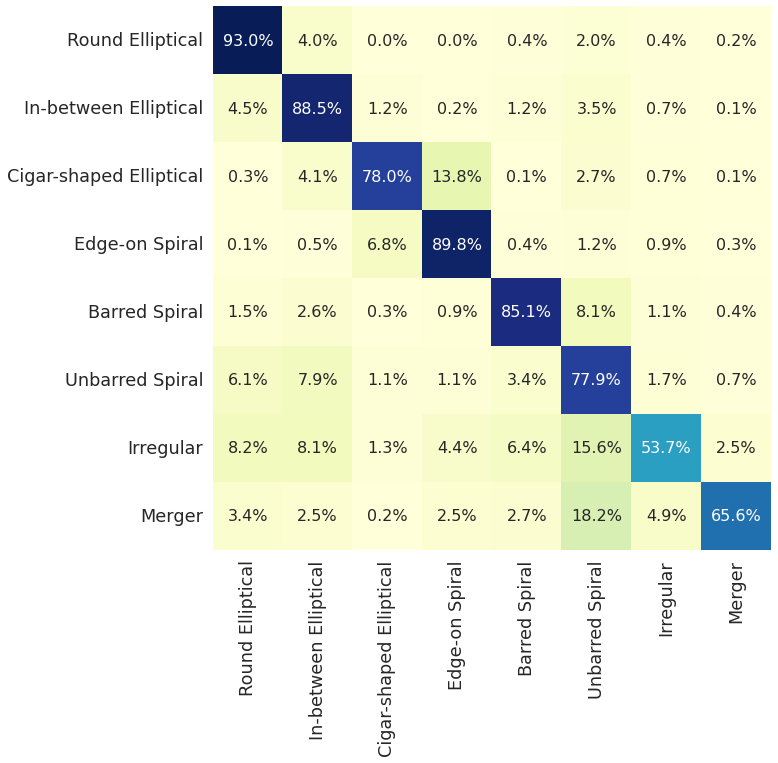

In [13]:
evaluate_model(model, test_loader, device)

## Model Predictions

In [14]:
def predict_model(model, data_loader):
    """
    Predict on training/validation/test data (all without augmentations)
    """

    # evaluation
    model.eval()

    # empty lists for results
    y_true = []
    y_pred = []
    y_label = []

    for images, labels, galaxy_id in data_loader:
        images = images.to(device)
        labels = labels.long().to(device)

        with torch.no_grad():
            outputs = model(images)
            pred_logits = outputs.logits
            _, pred_classes = torch.max(pred_logits.detach(), dim=1)

            y_true += torch.squeeze(labels.cpu()).tolist()
            y_pred += torch.squeeze(pred_classes).tolist()
            y_label += torch.squeeze(galaxy_id.cpu()).tolist()
    
    # create a DataFrame with columns 'GalaxyID', 'class', 'predicted labels'
    predict_df = pd.DataFrame(data={'GalaxyID': y_label, 'class': y_true, 'pred': y_pred})

    return y_true, y_pred, predict_df

In [15]:
# move to gpu
model = model.to(device)

# predict
_, _, train_df = predict_model(model, train_loader)
_, _, valid_df = predict_model(model, valid_loader)
_, _, test_df = predict_model(model, test_loader)

In [16]:
# combine dataframes
df = pd.concat([train_df, valid_df, test_df])
print(df.shape)
df.head()

(155951, 3)


,GalaxyID,class,pred
0,247233,5,1
1,98167,5,5
2,85016,4,4
3,95326,3,3
4,81017,2,3


## Display Attention Maps

In [69]:
def vit_attention_map_randomBatch(model, data_loader, df, device):
    """
    Extract the attention map of ViT from random sampled images
    Args:
        model: vit model
        data_loader: train/validation/test data loader
        df: the dataframe containing the true/predicted labels
        device: gpu or cpu
    """
    # move to gpu
    model = model.to(device)
    # evaluation
    model.eval()

    # galaxy categories
    gxy_labels = ['Round Elliptical', 'In-between Elliptical','Cigar-shaped Elliptical',
                  'Edge-on Spiral','Barred Spiral','Unbarred Spiral','Irregular','Merger']
    
    for images, _, galaxy_id in data_loader:
        images = images.to(device)
        with torch.no_grad():
            return_dict = model.config.use_return_dict
            outputs = model.vit(images, output_attentions=True, output_hidden_states=True, return_dict=return_dict)

            fig, axs = plt.subplots(14, 8, figsize=(20, 30))
            for idx in range(images.cpu().numpy().shape[0]):
                if idx >= 8:
                    break
                # image (need to convert to cv2 format)
                img = images[idx].cpu().numpy()
                img *= 0.5
                img += 0.5
                img = np.transpose(img, (1, 2, 0))  # (224, 224, 3)
                img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                # galaxy ID
                gal_id = galaxy_id[idx].cpu().numpy()
                # y_true
                y_true = gxy_labels[df[df['GalaxyID']==gal_id]['class'].values[0]]
                # y_pred
                y_pred = gxy_labels[df[df['GalaxyID']==gal_id]['pred'].values[0]]

                
                axs[0][idx].imshow(img)
                axs[0][idx].set_title("ID:{}\nClass: {}\nPred: {}".format(gal_id, y_true, y_pred), fontsize=10)
                axs[0][idx].axis('off')

                # attention averaged over all heads
                attn_matrices = []
                for layer_i in range(12):
                    # average all heads
                    attn = np.mean(outputs[2][layer_i][idx].cpu().numpy(), axis=0)  # (197, 197)
                    # add residual
                    attn += np.identity(attn.shape[0])  # (197, 197)
                    # normalize
                    attn = attn/2  # (197, 197)
                    # recurvie multiply the attention matrices
                    if layer_i != 0:
                        attn = np.matmul(attn, attn_matrices[layer_i-1])
                    # append to list
                    attn_matrices.append(attn)
                    # attn map
                    attn_map = np.array(attn[0, 1:]).reshape(14, 14)
                    # normalize
                    attn_map = attn_map / attn_map.max()
                    # attn mask
                    attn_mask = cv2.resize(attn_map, (224, 224))[..., None]
                    attn_mask = np.concatenate((attn_mask, attn_mask, attn_mask), axis=2)
                
                axs[1, idx].imshow(attn_mask[..., 0], cmap='jet')
                axs[1, idx].set_title("Attn (avg)", fontsize=10)
                axs[1, idx].axis('off')


                ## attention of individual heads
                head_attn_matrices = [[] for _ in range(12)]
                for h_idx in range(12):
                    for layer_i in range(12):
                        # individual head
                        attn = outputs[2][layer_i][idx].cpu().numpy()[h_idx]  # (197, 197)
                        # add residual
                        attn += np.identity(attn.shape[0])  # (197, 197)
                        # normalize
                        attn = attn/2  # (197, 197)
                        # recurvie multiply the attention matrices
                        if layer_i != 0:
                            attn = np.matmul(attn, head_attn_matrices[h_idx][layer_i-1])
                        # append to list
                        head_attn_matrices[h_idx].append(attn)
                    # attn map
                    attn_map = np.array(attn[0, 1:]).reshape(14, 14)
                    # normalize
                    attn_map = attn_map / attn_map.max()
                    # attn mask
                    attn_mask = cv2.resize(attn_map, (224, 224))[..., None]
                    attn_mask = np.concatenate((attn_mask, attn_mask, attn_mask), axis=2)

                    axs[2+h_idx, idx].imshow(attn_mask[..., 0], cmap='jet')
                    axs[2+h_idx, idx].set_title("Head #{}".format(1+h_idx), fontsize=10)
                    axs[2+h_idx, idx].axis('off')

        plt.show()
        break


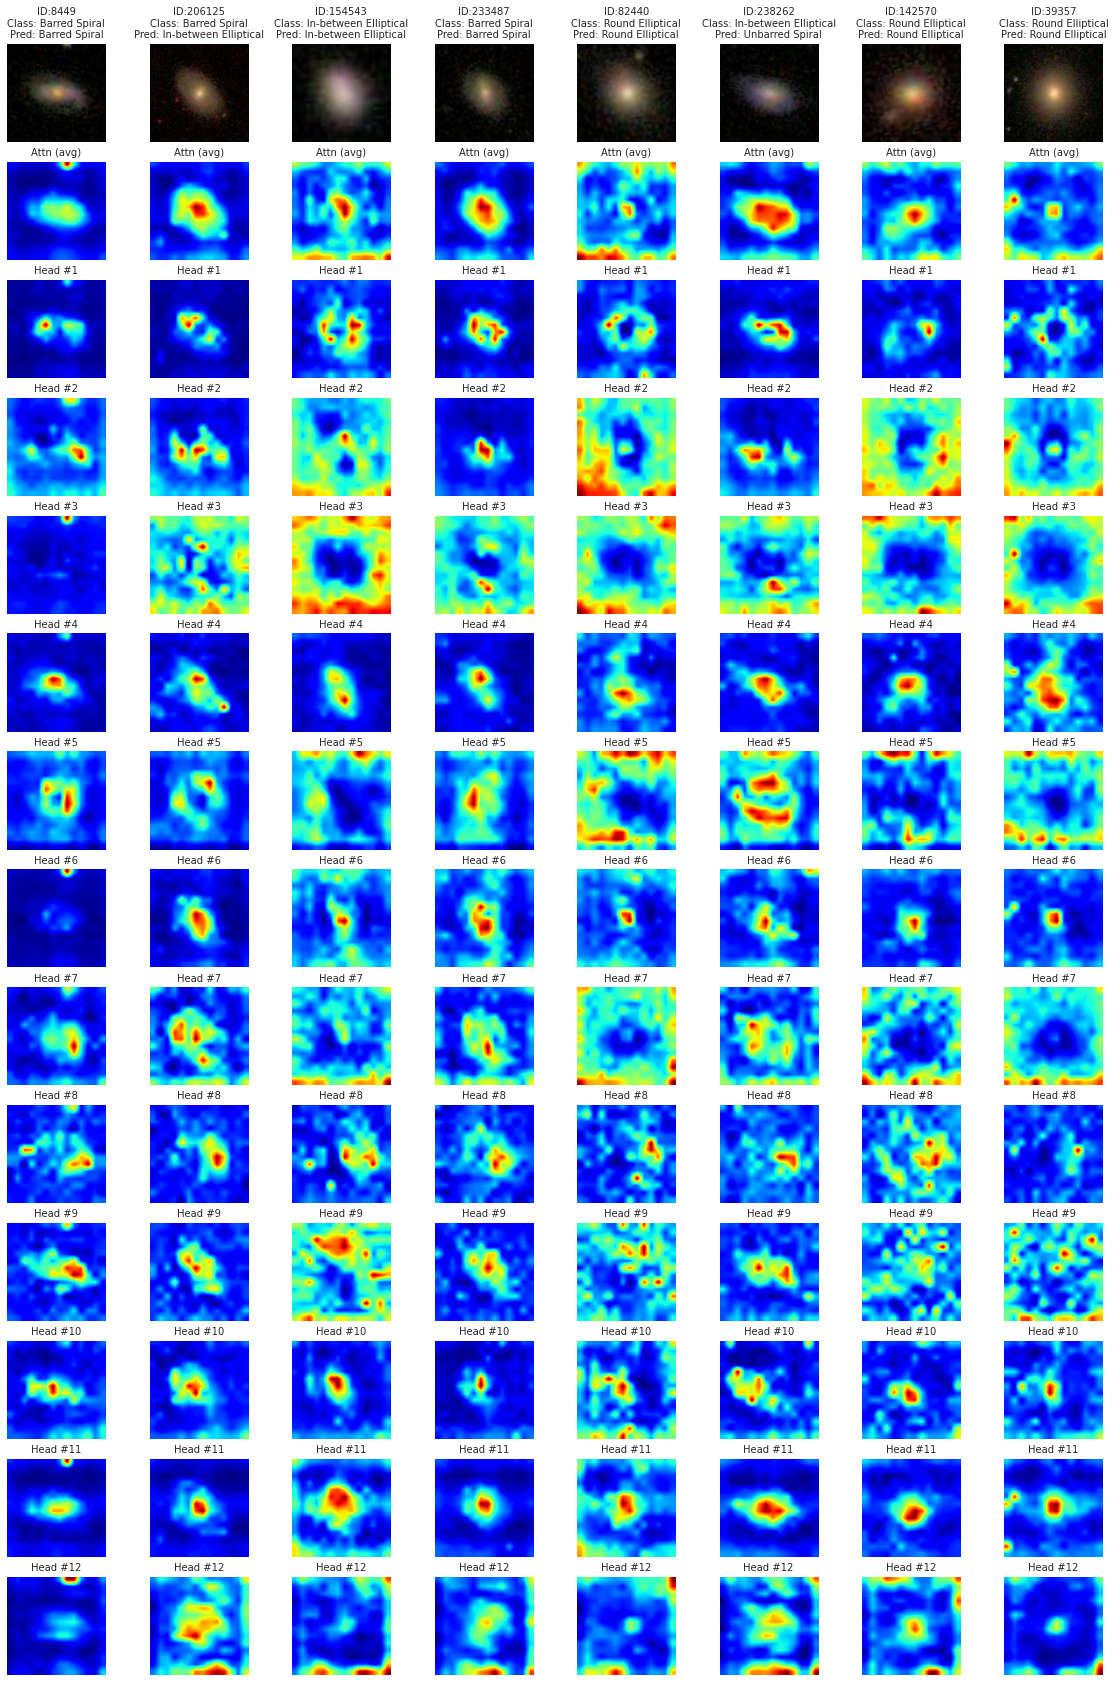

In [70]:
vit_attention_map_randomBatch(model, valid_loader, df, device)

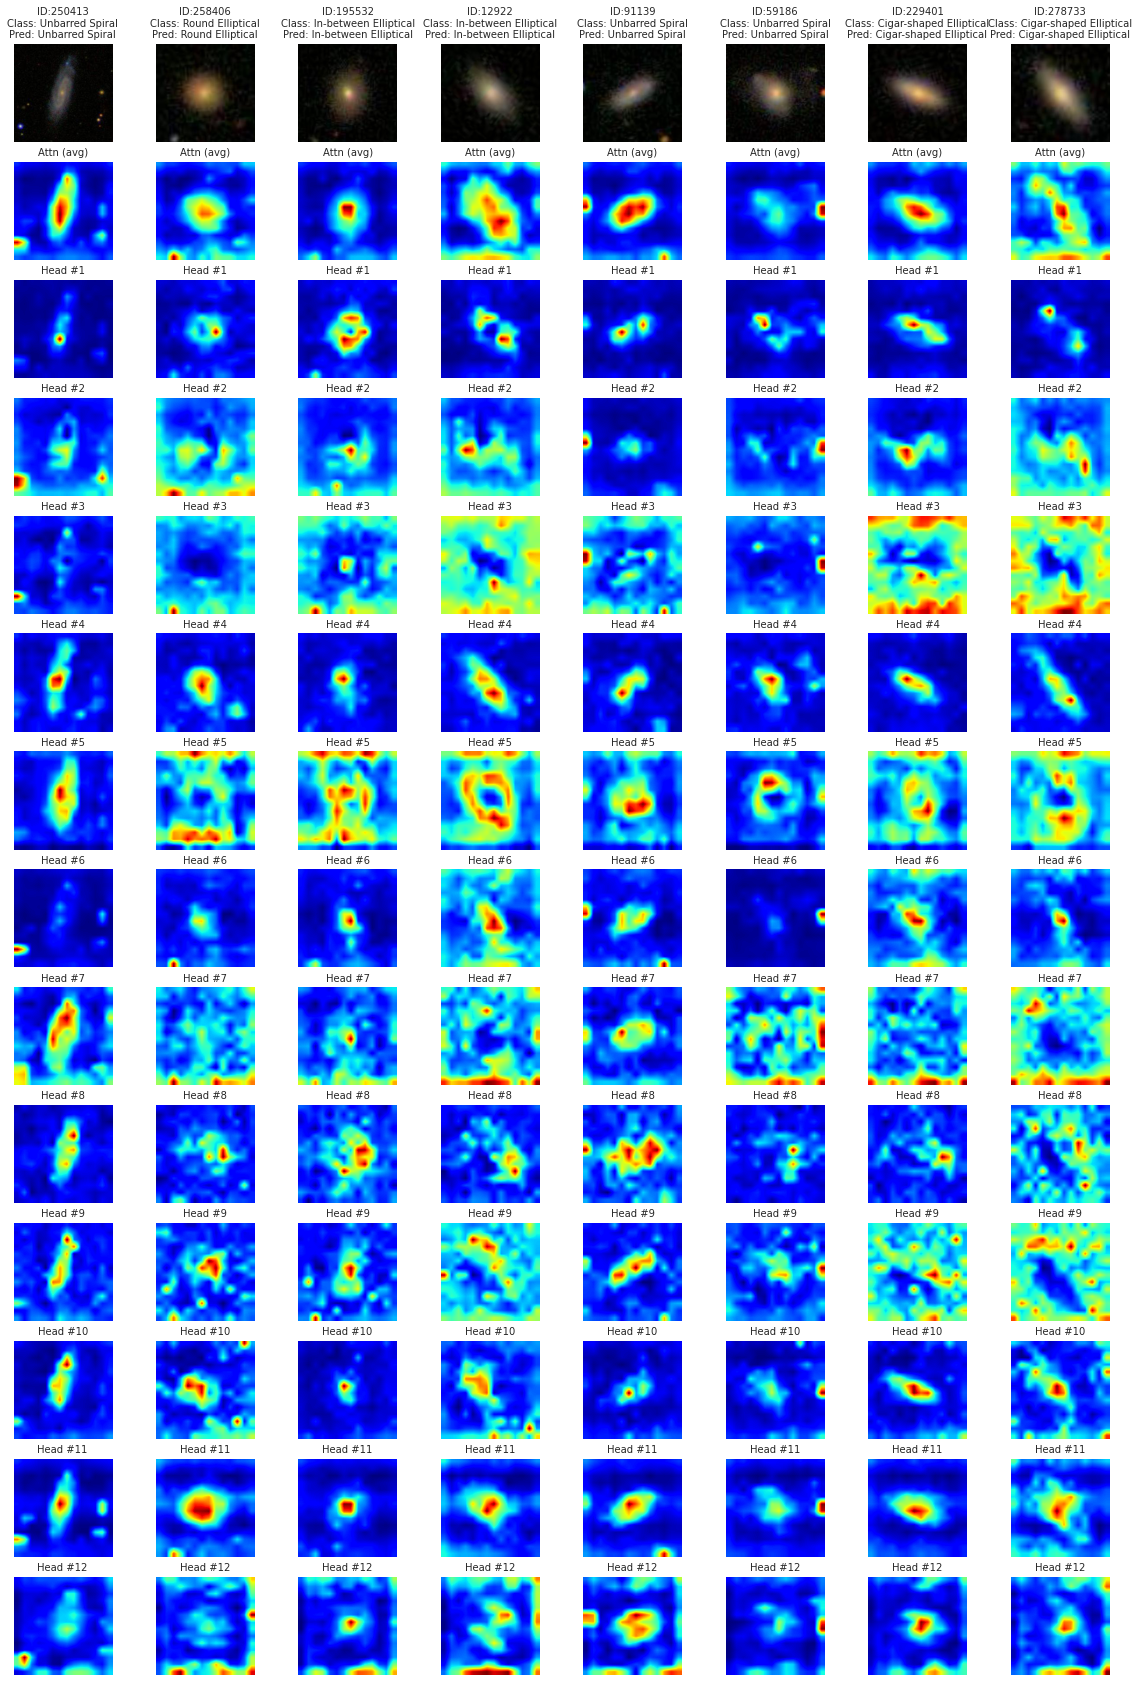

In [71]:
vit_attention_map_randomBatch(model, valid_loader, df, device)